In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Error processing files in /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test/vanilla_n_stores/run_2025-04-22_21-59-28/run_97122_00145_145_config=n_stores_lost_demand,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0.0010,mas_2025-04-22_21-59-32: No columns to parse from file
Error processing files in /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test/vanilla_n_stores/run_2025-04-22_21-59-28/run_97122_00021_21_config=n_stores_lost_demand,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0.0100,mast_2025-04-22_21-59-31: No columns to parse from file
Error processing files in /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test/n_stores_shared_net/run_2025-04-20_11-54-59/run_d0172_00020_20_config=n_stores_lost_demand,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0.0001,mast_2025-04-20_11-55-01: Expecting value: line 1 column 1 (char 0)
Error processing files in /user/ml

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error processing files in /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test/n_stores_per_store_net/run_2025-04-20_11-54-16/run_b6573_00007_7_config=n_stores_lost_demand,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0.0010,n_sto_2025-04-20_11-54-17: No columns to parse from file
   # of stores  train_dev_sample_and_batch_size      Architecture Class  n_stores  Train Loss  Dev Loss  Test Loss  Test Gap %                                                                                                                                                                                                                                                                       path
0            3                             1024        vanilla_n_stores         3    5.104752  5.107074   5.113914    0.181352        /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test/vanilla_n_stores/run_2025-04-22_21-59-28/run_97122_00215_215_config=n_stores_lost

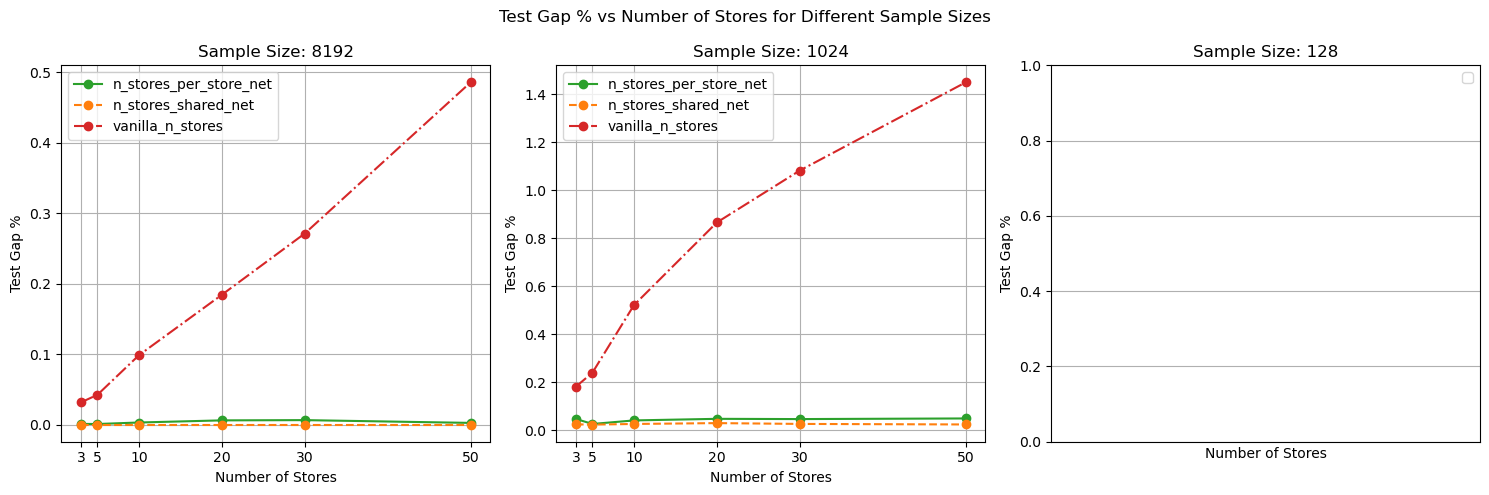

In [2]:
# Define color scheme for architecture types
color_scheme = {
    "n_stores_per_store_net": "#2ca02c",  # Green
    "n_stores_shared_net": "#ff7f0e",  # Orange
    "vanilla_n_stores": "#d62728"  # Red
}

linestyle_scheme = {
    "n_stores_per_store_net": "-",  # Solid
    "n_stores_shared_net": "--",  # Dashed 
    "vanilla_n_stores": "-."  # Dash-dot
}

testset_name = "models_overfit_in_many_stores_test"

# Define architectures with their path patterns
architectures = {
    "vanilla_n_stores": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_stores',
    "n_stores_shared_net": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_shared_net',
    "n_stores_per_store_net": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_per_store_net'
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define number of stores and sample sizes
n_stores = [3, 5, 10, 20, 30, 50]
sample_sizes = [8192, 1024, 128]

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

results_interpretor = rri.RayResultsinterpreter()

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    for n_store in n_stores:
        path = path_fn(n_store)
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes, 'n_stores': n_store},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        
        if not df.empty:
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['n_stores'] = n_store
            df['# of stores'] = n_store
            dfs.append(df)
df = pd.concat(dfs)

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'train_dev_sample_and_batch_size'], inplace=True)

df_to_print = df.copy()
df_to_analyze = df_to_print.copy()
columns_to_drop = ['Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create plot grid for different sample sizes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Test Gap % vs Number of Stores for Different Sample Sizes')

for idx, sample_size in enumerate(sample_sizes):
    df_sample = df[df['train_dev_sample_and_batch_size'] == sample_size]
    pivot_df = df_sample.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].min().unstack()
    
    ax = axes[idx]
    for column in pivot_df.columns:
        ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
                marker='o',
                label=column,
                color=color_scheme[column],
                linestyle=linestyle_scheme[column])
    
    ax.set_xlabel('Number of Stores')
    ax.set_ylabel('Test Gap %')
    ax.set_title(f'Sample Size: {sample_size}')
    ax.grid(True)
    ax.set_xticks(pivot_df.index)
    ax.legend()  # Show legend on each subplot

plt.tight_layout()
plt.show()

In [3]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,n_stores,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,Test Gap %,path
0,10,n_stores_shared_net,8192,n_stores_shared_net,10,0.010,5.264682,5.259911,5.261260,1,0.000000,/user/ml4723/Prj/NIC/ray_results/models_overfi...
0,20,n_stores_shared_net,8192,n_stores_shared_net,20,0.001,5.366177,5.372453,5.367041,3,0.000000,/user/ml4723/Prj/NIC/ray_results/models_overfi...
0,20,n_stores_per_store_net,8192,n_stores_per_store_net,20,0.001,5.366367,5.373311,5.368177,2,0.021171,/user/ml4723/Prj/NIC/ray_results/models_overfi...
0,30,n_stores_shared_net,8192,n_stores_shared_net,30,0.010,5.107560,5.109936,5.108932,3,0.000000,/user/ml4723/Prj/NIC/ray_results/models_overfi...
0,30,n_stores_per_store_net,8192,n_stores_per_store_net,30,0.001,5.107604,5.110753,5.109725,3,0.015534,/user/ml4723/Prj/NIC/ray_results/models_overfi...
0,50,vanilla_n_stores,8192,vanilla_n_stores,50,0.001,4.935146,4.955098,4.958395,8,0.558393,/user/ml4723/Prj/NIC/ray_results/models_overfi...
0,50,n_stores_shared_net,8192,n_stores_shared_net,50,0.010,4.930367,4.927840,4.930861,3,0.000000,/user/ml4723/Prj/NIC/ray_results/models_overfi...
0,50,n_stores_per_store_net,8192,n_stores_per_store_net,50,0.010,4.932148,4.931364,4.934321,3,0.070181,/user/ml4723/Prj/NIC/ray_results/models_overfi...
